<a href="https://colab.research.google.com/github/GangDu/ML-Study-Jam/blob/master/Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
x = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y = tf.constant([[10.0], [20.0]])

class Linear(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = tf.keras.layers.Dense(
            units=1,
            activation=None,
            kernel_initializer=tf.zeros_initializer(),
            bias_initializer=tf.zeros_initializer()
        )
    
    def call(self, input):
        output = self.dense(input)
        return output
    
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
for i in range(100):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = tf.reduce_mean(tf.square(y_pred - y))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
print(model.variables)

[<tf.Variable 'linear_1/dense_9/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[0.40784457],
       [1.1910652 ],
       [1.9742857 ]], dtype=float32)>, <tf.Variable 'linear_1/dense_9/bias:0' shape=(1,) dtype=float32, numpy=array([0.78322065], dtype=float32)>]


In [ ]:
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)
        self.train_label = self.train_label.astype(np.int32)
        self.test_label = self.test_label.astype(np.int32)
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]
        
    def get_batch(self, batch_size):
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]

In [ ]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)
        
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        output = tf.nn.softmax(x)
        return output

In [ ]:
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=[5, 5],
            padding='same',
            activation=tf.nn.relu
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[5, 5],
            padding='same',
            activation=tf.nn.relu
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))
        self.dense1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        output = tf.nn.softmax(x)
        return output

In [ ]:
num_epochs = 0.1
batch_size = 50
learning_rate = 0.001

# model = MLP()
model = CNN()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

test accuracy: 0.951000


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

num_epoch = 5
batch_size = 50
learning_rate = 0.001

dataset = tfds.load("tf_flowers", split=tfds.Split.TRAIN, as_supervised=True)
dataset = dataset.map(lambda img, label: (tf.image.resize(img, (224, 224)) / 255.0, label)).shuffle(1024).batch(batch_size)
model = tf.keras.applications.MobileNetV2(weights=None, classes=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for e in range(num_epoch):
    for images, labels in dataset:
        with tf.GradientTape() as tape:
            labels_pred = model(images, training=True)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=labels, y_pred=labels_pred)
            loss = tf.reduce_mean(loss)
        print("loss %f" % loss.numpy())
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
    print(labels_pred)

In [ ]:
image = np.array([[
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 2, 1, 0],
    [0, 0, 2, 2, 0, 1, 0],
    [0, 1, 1, 0, 2, 1, 0],
    [0, 0, 2, 1, 1, 0, 0],
    [0, 2, 1, 1, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
    ]], dtype=np.float32)
image = np.expand_dims(image, axis=-1)
W = np.array([[
    [ 0, 0, -1], 
    [ 0, 1, 0 ], 
    [-2, 0, 2 ]
    ]], dtype=np.float32)
b = np.array([1], dtype=np.float32)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=[3, 3],
        kernel_initializer=tf.constant_initializer(W),
        bias_initializer=tf.constant_initializer(b)
    )]
)
output = model(image)
print(tf.squeeze(output))

tf.Tensor(
[[ 6.  5. -2.  1.  2.]
 [ 3.  0.  3.  2. -2.]
 [ 4.  2. -1.  0.  0.]
 [ 2.  1.  2. -1. -3.]
 [ 1.  1.  1.  3.  1.]], shape=(5, 5), dtype=float32)


In [ ]:
class DataLoader():
    def __init__(self):
        path = tf.keras.utils.get_file('nietzsche.txt',
            origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
        with open(path, encoding='utf-8') as f:
            self.raw_text = f.read().lower()
        self.chars = sorted(list(set(self.raw_text)))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.text = [self.char_indices[c] for c in self.raw_text]
    def get_batch(self, seq_length, batch_size):
        seq = []
        next_char = []
        for i in range(batch_size):
            index = np.random.randint(0, len(self.text) - seq_length)
            seq.append(self.text[index:index+seq_length])
            next_char.append(self.text[index+seq_length])
        return np.array(seq), np.array(next_char)

In [ ]:
class RNN(tf.keras.Model):
    def __init__(self, num_chars, batch_size, seq_length):
        super().__init__()
        self.num_chars = num_chars
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.cell = tf.keras.layers.LSTMCell(units=256)
        self.dense = tf.dense = tf.keras.layers.Dense(units=self.num_chars)
    
    def call(self, inputs, from_logits=False):
        inputs = tf.one_hot(inputs, depth=self.num_chars)
        state = self.cell.get_initial_state(batch_size=self.batch_size, dtype=tf.float32)
        for t in range(self.seq_length):
            output, state = self.cell(inputs[:, t, :], state)
        logits = self.dense(output)
        if from_logits:
            return logits
        else:
            return tf.nn.softmax(logits)
    
    def predict(self, inputs, temperature=1.):
        batch_size, _ = tf.shape(inputs)
        logits = self(inputs, from_logits=True)
        prob = tf.nn.softmax(logits / temperature).numpy()
        return np.array([np.random.choice(self.num_chars, p=prob[i, :])
                for i in range(batch_size.numpy())])

In [ ]:
num_batches = 100
seq_length = 40
batch_size = 50
learning_rate = 1e-3

data_loader = DataLoader()
model = RNN(num_chars=len(data_loader.chars), batch_size=batch_size, seq_length=seq_length)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(seq_length, batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

In [ ]:
X_, _ = data_loader.get_batch(seq_length, 1)
for diversity in [0.2, 0.5, 1.0, 1.2]:
    X = X_
    print("diversity %f:" % diversity)
    for t in range(400):
        y_pred = model.predict(X, diversity)
        print(data_loader.indices_char[y_pred[0]], end='', flush=True)
        X = np.concatenate([X[:, 1:], np.expand_dims(y_pred, axis=1)], axis=-1)
    print("\n")

diversity 0.200000:
    o  n       o      t   t et n        t s   in       t        o    t    t   t                    t  s            t  i   te       t   n          n          t  c   l    o                t   n  t t   st   n ,    e      l                   e o t  t t       e  t   o o       n     n  e    t           i       n  t      i          s   o o     e    e       o  t     o e          n    e     t           t  

diversity 0.500000:
n enttt  os aoeht sl t  wnntsceia    e 
  ent olh tit t sor snre  io tle  eee reldi sitnegesd   er dot oio   n l nei ts  t u  a t uthiuom  ie no ae  i t te  g e it eo i  i t  l eefto  s a li  o nt taln w sts f tl  ntit ano  tno   g,at  tes  lni sr t eo si e  ntcttttitet o    cn
st fe  sw isats  coosot  rn  e  nn  e  touno oass ne im elet ,hoi i nheul gt oe  luono srsn ofb e ng se  t es,it ooitllon

diversity 1.000000:
i - stsoorhlacnopiesrrsocvgtufg    alf neewowc kdemgtoudxnug,eovtbisngolou edauomtlratss  aethlcg affcrehodniantdr
oun hc
id k oanisrofe

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import tensorflow as tf
import numpy as np
import gym
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

num_episodes = 500
num_exploration_episodes = 100
max_len_episode = 1000
batch_size = 32
learning_rate = 1e-3
gamma = 1.
initial_epsilon = 1.
final_epsilon = 0.01

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
class QNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=24, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=24, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(units=2)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(inputs)
        x = self.dense3(x)
        return x
    
    def predict(self, inputs):
        q_values = self(inputs)
        return tf.argmax(q_values, axis=-1)

KeyboardInterrupt: ignored

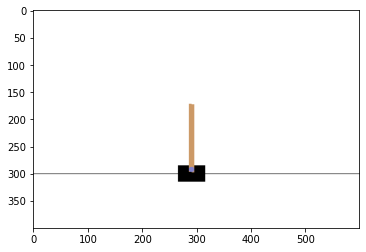

In [ ]:
env = gym.make('CartPole-v1')
model = QNetwork()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
replay_buffer = deque(maxlen=10000)
epsilon = initial_epsilon
for episode_id in range(num_episodes):
    state = env.reset()
    epsilon = max(
        initial_epsilon * (num_exploration_episodes - episode_id) / num_exploration_episodes,
        final_epsilon
    )
    for t in range(max_len_episode):
        img = plt.imshow(env.render(mode='rgb_array'))
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = model.predict(np.expand_dims(state, axis=0)).numpy()
            action = action[0]
        next_state, reward, done, info = env.step(action)
        reward = -10 if done else reward
        replay_buffer.append((state, action, reward, next_state, 1 if done else 0))
        state = next_state
        
        if done:
            print("episode %d, epsilon %f, score %d" % (episode_id, epsilon, t))
            break
        if len(replay_buffer) >= batch_size:
            batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(
                *random.sample(replay_buffer, batch_size))
            batch_state, batch_reward, batch_next_state, batch_done = \
                [np.array(a, dtype=np.float32) for a in [batch_state, batch_reward, batch_next_state, batch_done]]
            batch_action = np.array(batch_action, dtype=np.int32)

            q_value = model(batch_next_state)
            y = batch_reward + (gamma * tf.reduce_max(q_value, axis=1)) * (1 - batch_done)
            with tf.GradientTape() as tape:
                loss = tf.keras.losses.mean_squared_error(
                    y_true=y,
                    y_pred=tf.reduce_sum(model(batch_state) * tf.one_hot(batch_action, depth=2), axis=1)
                )
            grads = tape.gradient(loss, model.variables)
            optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Softmax()
])

In [ ]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dense(units=10)(x)
outputs = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

num_epochs = 10
batch_size = 50

data_loader = MNISTLoader()
model.fit(data_loader.train_data, data_loader.train_label, epochs=num_epochs, batch_size=batch_size)

Epoch 1/10
1200/1200 [==============================] - 3s 2ms/step - loss: 0.2993 - sparse_categorical_accuracy: 0.9164
Epoch 2/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9608
Epoch 3/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0982 - sparse_categorical_accuracy: 0.9710
Epoch 4/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9780
Epoch 5/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0590 - sparse_categorical_accuracy: 0.9821
Epoch 6/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9848
Epoch 7/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9881
Epoch 8/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9904
Epoch 9/10
1200/1200 [==========

In [ ]:
print(model.evaluate(data_loader.test_data, data_loader.test_label))

313/313 [==============================] - 0s 1ms/step - loss: 0.0772 - sparse_categorical_accuracy: 0.9765
[0.07722032815217972, 0.9764999747276306]


In [ ]:
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_variable(name='w',
            shape=[input_shape[-1], self.units], initializer=tf.zeros_initializer())
        self.b = self.add_variable(name='b',
            shape=[self.units], initializer=tf.zeros_initializer())
    
    def call(self, inputs):
        y_pred = tf.matmul(inputs, self.w) + self.b
        return y_pred

In [ ]:
class LinearModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.layer = LinearLayer(units=1)

    def call(self, inputs):
        output = self.layer(inputs)
        return output

In [ ]:
class MeanSquaredError(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_pred - y_true))

In [ ]:
class SparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self):
        super.__init__()
        self.total = self.add_weight(name='total', dtype=tf.int32, initializer=tf.zeros_initializer())
        self.count = self.add_weight(name='count', dtype=tf.int32, initializer=tf.zeros_initializer())

    def update_state(self, y_true, y_pred, sample_weight=None):
        values = tf.cast(tf.equal(y_true, tf.argmax(y_pred, axis=-1, output_type=tf.int32)), tf.int32)
        self.total.assign_add(tf.shape(y_true)[0])
        self.count.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.count / self.total